# Semantic Occupancy Prediction in BEV from a Single Camera (nuScenes-mini)
**What you will build**

A model that takes CAM_FRONT RGB and predicts a BEV semantic occupancy map:

- A 2D grid in the ego frame (x forward, y left)

- Each cell is one semantic label:

    - 0 empty

    - 1 vehicle

    - 2 pedestrian

    - 3 bike/motorcycle

**What “semantic occupancy” means here**

In full 3D occupancy, we predict whether each voxel in 3D space is occupied and by what class.
In this lab, we simplify to BEV semantic occupancy:

- For each BEV cell (a ground-plane location), we predict which object class occupies it.

Important: this notebook uses pseudo-labels

nuScenes does not provide dense occupancy labels by default. We create pseudo-labels by rasterizing the footprints of 3D bounding boxes in BEV.

---

## 1) Setup: install libraries and mount dataset
We need:

- nuscenes-devkit: official API for reading nuScenes metadata and annotations

- pyquaternion: used by the devkit to represent rotations

- opencv-python-headless: sometimes required for image I/O utilities in headless environments

### 1.1 Install and load packages and download the nuScenes-mini dataset
Install and restart

In [1]:
# !wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.

# !tar -xf v1.0-mini.tgz -C /data/sets/nuscenes  # Uncompress the nuScenes mini split.

# !pip -q install nuscenes-devkit pyquaternion opencv-python-headless


Imports & nuScenes API initialization
nuScenes is organized like a relational database:

- **scene**: a short driving sequence

- **sample**: a time step (frame) inside the scene

- **sample_data**: a sensor record for a sample (e.g., CAM_FRONT image file)

- **sample_annotation**: an object annotation (3D bounding box) tied to a sample

The devkit gives NuScenes(...) which loads these tables into memory and provides helper functions.

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import Box
from pyquaternion import Quaternion

### 1.2 Data: provide nuScenes-mini
The downloaded data should look like this

### Explanation

- nuScenes expects a “root folder” containing sensor files and metadata tables.

- samples/ contains keyframe images.

- sweeps/ contains intermediate frames (we are not using them here, but included).

- maps/ contains map assets (not used in this notebook).

- v1.0-mini/ contains JSON tables: scenes, samples, annotations, etc.

This tutorial expects a dataroot containing samples/, sweeps/, maps/, and the metadata folder for the chosen version

In [2]:
DATA_ROOT = "./datasets/nuScenes/v1.0-mini/"  # change if needed
VERSION = "v1.0-mini"

import os
assert os.path.exists(DATA_ROOT), f"DATA_ROOT not found: {DATA_ROOT}"
for req in ["samples", "sweeps", "maps", VERSION]:
    assert os.path.exists(os.path.join(DATA_ROOT, req)), f"Missing {req} under {DATA_ROOT}"
print("nuScenes-mini folder structure looks OK.")

nuScenes-mini folder structure looks OK.


## This is how the cameras are placed on a car for the nuscene datasets
<img src="nuscene_cam.png" width="800">

### 1.3 Load nuScenes and inspect one sample


In [3]:
nusc = NuScenes(version=VERSION, dataroot=DATA_ROOT, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.252 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


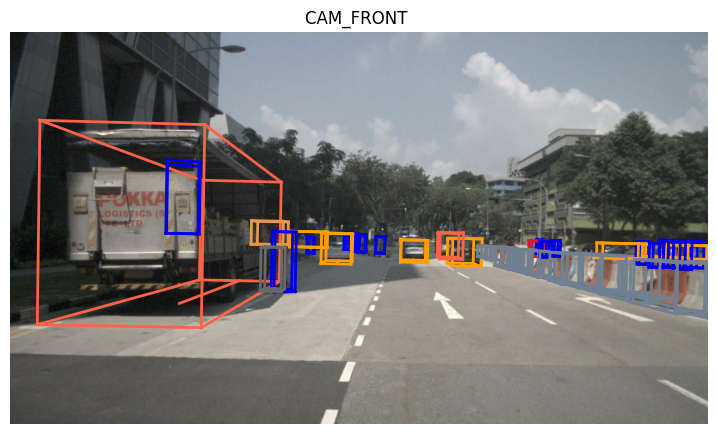

In [22]:
import matplotlib.pyplot as plt

scene = nusc.scene[0]
sample = nusc.get("sample", scene["first_sample_token"])
cam_token = sample["data"]["CAM_FRONT"]

# devkit visualization (draws 3D boxes on the image)
nusc.render_sample_data(cam_token)
plt.show()

---

## 2) Define BEV grid
### **Theory: what the BEV grid represents**

We discretize a 2D region around the vehicle into a grid (Bird’s-Eye View).
Each cell corresponds to a patch of ground in meters.

We choose:

- x axis: forward, range [0, 40] m

- y axis: left, range [-20, 20] m

resolution: 0.8 m

This gives:

- X = (x_max - x_min) / dx columns

- Y = (y_max - y_min) / dy rows

We store BEV arrays as shape (Y, X):

- row index corresponds to y (left-right)

- col index corresponds to x (front-back)

### 2.1 Grid config

In [4]:
GRID = dict(
    x_min=0.0, x_max=40.0, dx=0.8,
    y_min=-20.0, y_max=20.0, dy=0.8,
)

X = int((GRID["x_max"] - GRID["x_min"]) / GRID["dx"])
Y = int((GRID["y_max"] - GRID["y_min"]) / GRID["dy"])
print("BEV size:", Y, X)


BEV size: 50 50


### 2.2 Precompute BEV cell centers
**Why we compute centers**
To rasterize box footprints into grid cells, we need a representative point per cell.
A standard rule is: the cell is occupied if its center lies inside the object footprint.

**Shapes**

- BEV_CENTERS: (Y, X, 2) where the last dimension is [x, y] in meters.

**Key lines explained**
- linspace(min + dx/2, max - dx/2, X) generates center coordinates for each grid cell along x.

- meshgrid(..., indexing="ij") creates coordinate grids where the first dimension corresponds to rows (y) and second to columns (x).

- stack([xx, yy], axis=-1) forms [x, y] coordinates.

In [6]:
def bev_centers(cfg):
    xs = np.linspace(cfg["x_min"] + cfg["dx"]/2, cfg["x_max"] - cfg["dx"]/2, X)
    ys = np.linspace(cfg["y_min"] + cfg["dy"]/2, cfg["y_max"] - cfg["dy"]/2, Y)
    yy, xx = np.meshgrid(ys, xs, indexing="ij")
    return np.stack([xx, yy], axis=-1)  # (Y,X,2)

BEV_CENTERS = bev_centers(GRID)


---

## 3) Define classes + category mapping
### **What we are predicting**

For each BEV cell, predict one of:

- 0: empty

- 1: vehicle

- 2: pedestrian

- 3: bicycle/motorcycle

### ** Why we collapse categories**

nuScenes has many categories. For a TA exercise, coarse categories:

- reduce label noise,

- allow faster learning,

- simplify metrics and analysis.

### **Priority rule (overlaps)**

If two boxes overlap in BEV, we choose a deterministic label:
pedestrian > bike > vehicle > empty.

### 3.1 Mapping function

In [7]:
def category_to_class(name):
    name = name.lower()
    if name.startswith("vehicle."):
        return 1
    if name.startswith("human.pedestrian"):
        return 2
    if "bicycle" in name or "motorcycle" in name:
        return 3
    return 0

NUM_CLASSES = 4  # empty, vehicle, pedestrian, bike



### 3.2 Priority rule
Multiple objects can overlap in BEV (rare but possible) and tall objects can project to the same BEV cell. We choose the most “important” label by priority:

pedestrian > bike/moto > vehicle > empty

In [ ]:
PRIORITY = {0:0, 1:1, 3:2, 2:3}     # Priority table for class labels (for resolving conflicts)

---

## 4) Global → ego box transform

**Why transform boxes**

Annotations are stored in global coordinates.
Our BEV grid is in the ego vehicle frame at the camera timestamp.

We get the ego pose at the CAM_FRONT sample_data timestamp:

- translation ego_t (global position of ego origin)

- rotation ego_q (global orientation of ego frame)

To transform global coordinates into ego:

1. translate by -ego_t to bring ego origin to (0,0,0)

2. rotate by ego_q.inverse to align axes to ego frame

**What this function returns**

A list of (Box_in_ego, class_id).

### 4.1 Convert annotations into ego grame

In [8]:
def get_boxes_ego(sample_token):
    """
    Returns list of (box_in_ego, coarse_class_id) for a given sample.
    We use the ego pose from CAM_FRONT to define the ego frame.
    """
    sample = nusc.get("sample", sample_token)
    cam_token = sample["data"]["CAM_FRONT"]
    sd = nusc.get("sample_data", cam_token)
    ego = nusc.get("ego_pose", sd["ego_pose_token"])

    t = np.array(ego["translation"])
    q = Quaternion(ego["rotation"])

    boxes = []
    for ann_tok in sample["anns"]:
        ann = nusc.get("sample_annotation", ann_tok)
        cls = category_to_class(ann["category_name"])
        if cls == 0:
            continue
        box = Box(
            center=ann["translation"],
            size=ann["size"],
            orientation=Quaternion(ann["rotation"]),
        )
        box.translate(-t)
        box.rotate(q.inverse)
        boxes.append((box, cls))
    return boxes


### 4.2 Rasterize oriented box footprint to BEV mask

**Goal**

Given one ego-frame 3D box, produce a boolean BEV mask (Y,X) of cells inside its footprint.

**Key theory: point-in-rotated-rectangle test**

We want to know if BEV cell center p lies inside the box footprint.
Instead of rotating the rectangle, we rotate points into the box’s local frame:

- In the box frame, the footprint is axis-aligned.

- Then check axis-aligned bounds.

**Shapes**

- Input: box (with center in ego frame, orientation quaternion)

- Output: mask boolean array (Y,X)

In [9]:
def box_to_bev_mask(box):
    """
    Projects a 3D box onto BEV as a rotated rectangle (footprint).
    We treat a BEV cell as occupied if its center lies inside the rectangle.
    """
    w, l, _ = box.wlh
    # We want points in the box local frame to do an axis-aligned inside-test.
    # Use inverse rotation for transforming global-ego points into box coordinates.
    R = box.orientation.inverse.rotation_matrix[:2,:2]
    p = BEV_CENTERS - box.center[:2]
    p = (R @ p.reshape(-1,2).T).T
    inside = (np.abs(p[:,0]) <= l/2) & (np.abs(p[:,1]) <= w/2)
    return inside.reshape(Y, X)


### 4.3 Build the BEV label map
**What this function does**
Creates sem (Y,X) initialized as empty.
For each box:

- compute its footprint mask

- write class label into those cells if higher priority

**Why priority**

Overlaps should not cause random labeling. Priority gives deterministic results.

In [10]:
def build_bev_gt(sample_token):
    """
    Returns BEV semantic labels: (Y, X), dtype int64 in [0..NUM_CLASSES-1]
    """
    bev = np.zeros((Y,X), np.int64)
    pr  = np.zeros_like(bev)

    for box, cls in get_boxes_ego(sample_token):
        mask = box_to_bev_mask(box)
        update = mask & (PRIORITY[cls] > pr)
        bev[update] = cls
        pr[update]  = PRIORITY[cls]
    return bev


---

## 5) Frustum mask: supervise only visible BEV

**Why frustum masking matters**
Your BEV grid includes areas not observable from a single front camera.
Supervising those areas makes training inconsistent.

We approximate a camera-visible wedge:

- x > 0 (in front of vehicle)

- |y| < k * x (wider with distance)

This is a teaching approximation, not exact projection geometry.

**Output**

FRUSTUM (Y,X) float mask, 1.0 inside, 0.0 outside.

### 5.1 Frustum mask

In [11]:
def bev_frustum_mask():
    xs = np.linspace(GRID["x_min"], GRID["x_max"], X)
    ys = np.linspace(GRID["y_min"], GRID["y_max"], Y)
    yy, xx = np.meshgrid(ys, xs, indexing="ij")
    return ((xx > 0) & (np.abs(yy) < 0.6 * xx)).astype(np.float32)

FRUSTUM = torch.from_numpy(bev_frustum_mask())


---

## 6) Dataset + loaders

Each sample returns:

- RGB image (CAM_FRONT), resized to keep training fast

- BEV pseudo-GT labels (Y, X)

### 6.1 Dataset

In [12]:
class NuScenesBEVDataset(Dataset):
    def __init__(self, tokens):
        self.tokens = tokens

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, i):
        tok = self.tokens[i]
        sample = nusc.get("sample", tok)
        cam = sample["data"]["CAM_FRONT"]
        sd = nusc.get("sample_data", cam)
        img = Image.open(os.path.join(DATA_ROOT, sd["filename"])).convert("RGB")
        img = img.resize((256,128))
        img = torch.from_numpy(np.array(img)).permute(2,0,1).float()/255

        bev = torch.from_numpy(build_bev_gt(tok)).long()
        return img, bev


### 6.2 Token collection + split

In [13]:
tokens = []
scene = nusc.scene[0]
tok = scene["first_sample_token"]
while tok:
    tokens.append(tok)
    tok = nusc.get("sample", tok)["next"]

np.random.shuffle(tokens)
train_ds = NuScenesBEVDataset(tokens[:int(0.8*len(tokens))])
val_ds   = NuScenesBEVDataset(tokens[int(0.8*len(tokens)):])


---

## **7) Model: Tiny BEV Net**

**Architecture idea**

We want a minimal “image → BEV” mapping:

- CNN encoder extracts features from the image.

- Adaptive pooling reshapes feature map to BEV size (Y,X).

- A small BEV refinement block makes predictions spatially smoother.

- A 1×1 head outputs class logits per BEV cell.

This is not geometry-based BEV (like LSS), but it is ideal for teaching:

- multi-task would be too much here; this is semantic-only.

Tensor shapes

- input: (B,3,H,W)

- logits: (B,C,Y,X)

### 7.1 Model

In [14]:
class TinyBEVNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3,32,3,2,1), nn.ReLU(),
            nn.Conv2d(32,64,3,2,1), nn.ReLU(),
            nn.Conv2d(64,128,3,2,1), nn.ReLU(),
        )
        self.mid = nn.Sequential(
            nn.Conv2d(128,64,1), nn.ReLU(),
            nn.Conv2d(64,64,3,1,1), nn.ReLU(),
            nn.Conv2d(64,64,3,1,1), nn.ReLU(),
        )
        self.head = nn.Conv2d(64, NUM_CLASSES, 1)

    def forward(self,x):
        f = self.enc(x)                             # (B, 128, H', W')
        f = F.adaptive_avg_pool2d(f,(Y,X))          # (B, 128, Y, X)
        f = self.mid(f)                             # (B, 64, Y, X) 
        return self.head(f)                         # (B, NUM_CLASSES, Y, X)


---

## **8) Loss: weighted + frustum-masked**

**Why weighting?**

Empty dominates. Without weights, the model can minimize loss by predicting empty everywhere.

**Why frustum-masked?**

We do not want to supervise regions that the camera cannot infer.

Implementation details:

- Compute per-pixel CE loss (reduction="none")

- Multiply by frustum mask

- Normalize by mask area

### 8.1 Setup training objects

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TinyBEVNet().to(device)

weights = torch.tensor([0.02,1.0,2.0,1.5], device=device)
criterion = nn.CrossEntropyLoss(weight=weights, reduction="none")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


---

## **9) Metrics**

We use mIoU on BEV. For interpretability, we often ignore empty in IoU because empty dominates.

### 9.1 IoU helper

In [ ]:
def compute_iou(pred, target, num_classes=NUM_CLASSES, ignore_class=0):
    ious = []
    for c in range(num_classes):
        if ignore_class is not None and c == ignore_class:
            continue
        p = (pred == c)
        t = (target == c)
        inter = (p & t).sum().item()
        union = (p | t).sum().item()
        if union == 0:
            continue
        ious.append(inter / union)
    return float(np.mean(ious)) if ious else 0.0

---

## **10) Train / eval loop**

We iterate:

- forward pass → logits (B,C,Y,X)

- compute loss map → (B,Y,X)

- apply frustum mask

- backprop


### 10.1 Training function

In [ ]:
def train_epoch(loader):
    model.train()
    total = 0
    for img, bev in loader:
        img, bev = img.to(device), bev.to(device)
        logits = model(img)
        loss_map = criterion(logits, bev)
        loss = (loss_map * FRUSTUM[None].to(device)).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += loss.item()
    return total / len(loader)

### 10.2 Run training

In [17]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
for e in range(1000):
    loss = train_epoch(train_loader)
    print(f"epoch {e:02d} loss {loss:.4f}")


epoch 00 loss 0.0483
epoch 01 loss 0.0478
epoch 02 loss 0.0469
epoch 03 loss 0.0459
epoch 04 loss 0.0431
epoch 05 loss 0.0376
epoch 06 loss 0.0318
epoch 07 loss 0.0311
epoch 08 loss 0.0313
epoch 09 loss 0.0303
epoch 10 loss 0.0294
epoch 11 loss 0.0299
epoch 12 loss 0.0298
epoch 13 loss 0.0294
epoch 14 loss 0.0294
epoch 15 loss 0.0294
epoch 16 loss 0.0292
epoch 17 loss 0.0289
epoch 18 loss 0.0289
epoch 19 loss 0.0290
epoch 20 loss 0.0290
epoch 21 loss 0.0290
epoch 22 loss 0.0290
epoch 23 loss 0.0289
epoch 24 loss 0.0290
epoch 25 loss 0.0297
epoch 26 loss 0.0293
epoch 27 loss 0.0289
epoch 28 loss 0.0289
epoch 29 loss 0.0289
epoch 30 loss 0.0291
epoch 31 loss 0.0288
epoch 32 loss 0.0286
epoch 33 loss 0.0286
epoch 34 loss 0.0286
epoch 35 loss 0.0284
epoch 36 loss 0.0282
epoch 37 loss 0.0284
epoch 38 loss 0.0282
epoch 39 loss 0.0283
epoch 40 loss 0.0286
epoch 41 loss 0.0286
epoch 42 loss 0.0283
epoch 43 loss 0.0283
epoch 44 loss 0.0282
epoch 45 loss 0.0282
epoch 46 loss 0.0277
epoch 47 loss

---

## 11) Visualization

We visualize:
- input CAM_FRONT image
- GT BEV
- predicted BEV

### 11.1 Plot helper

In [18]:
def show_bev(b, title):
    plt.figure(figsize=(5,5))
    plt.imshow(b, origin="lower")
    plt.title(title)
    plt.axis("off")
    plt.show()


### 11.2 Qualitative results

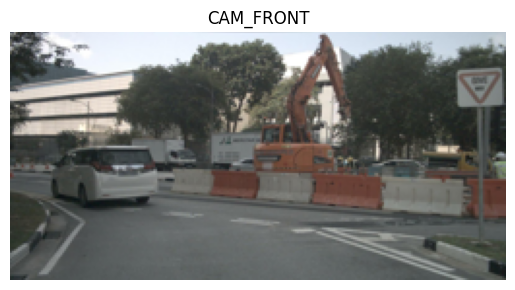

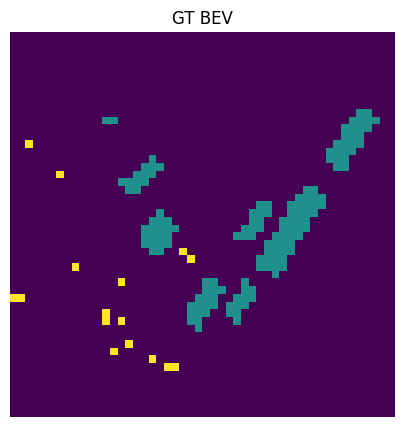

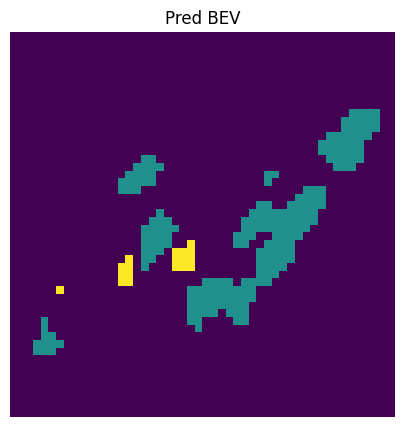

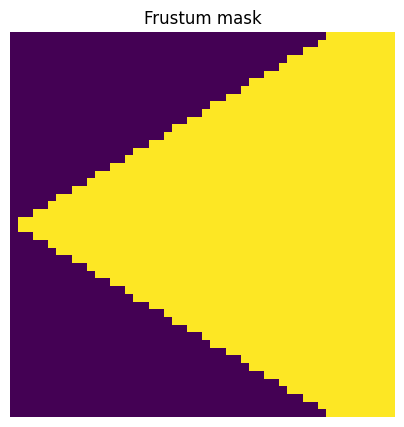

In [29]:
model.eval()
img, gt = train_ds[5]
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device)).argmax(1)[0].cpu()

plt.imshow(img.permute(1,2,0)); plt.title("CAM_FRONT"); plt.axis("off"); plt.show()
show_bev(gt.numpy(), "GT BEV")
show_bev(pred.numpy(), "Pred BEV")
show_bev(FRUSTUM.numpy(), "Frustum mask")
